Sampling from a distribution 

In this post, I'm going to explain some basics about Markov chain Monte Carlo (MCMC) algorithms, the Metropolis-Hastings algorithm and how they relate to sampling from a distribution.  I'll start off with some basics about MCMC, move on to explain the Metropolis-Hastings algorithm and then put it all together using an example with some code to make things concrete.
<!-- TEASER_END -->

## Background

Before we get into the meat of the subject, let's breakdown the term Markov chain Monte Carlo (MCMC) into it's basic components: Monte Carlo methods and Markov Chains.  With an understanding of these two, MCMC makes a whole lot more sense.

### Monte Carlo Methods

[Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) is a general term a broad class of algorithms that use random sampling to compute some numerical result.  It is often used when it is difficult or even impossible to compute things directly.  Example applications are optimization, numerical integration and sampling from a probability distribution. 

The key idea here is we're using some algorithm that uses random sampling to compute a result.  For example, if we can express the result as the expected value (read: integral) of a random variable, then by the law of large numbers, we can empirically compute the expected value using a bunch of independent random samples.  In the context of this post, we'll primarily be focused on methods to generate those independent random samples according to a particular distribution.  In fact, my previous post of [Sampling a Normal Distribution](link://slug/sampling-from-a-normal-distribution) is technically a Monte Carlo method (albeit a simple one).

### Markov Chains

A [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) is a "a random process that undergoes transitions from one state to another on a state space".  You can look up the formal definition on Wikipedia but informally, it's best described as a finite state machine where the transitions represent probabilities of going from one state to another.  Let's take a look at an example to make thing concrete from Wikipedia of a [simple weather model](https://en.wikipedia.org/wiki/Examples_of_Markov_chains#A_very_simple_weather_model) (image from Wikipedia):

![simple markov chain](/images/weather_markov_chain.png)

As you can see it looks just like a finish state machine except we've annotated the state transitions with probabilities.  For example, we can see if it's sunny today, there is a \\(0.9\\) chance of being sunny tomorrow and a \\(0.1\\) chance of being rainy.  Similarly starting in rainy state.  It should be clear that from a given state, all the outgoing transitions should total \\(1.0\\) since it's a proper distribution.

Another way to represent this information is via a transition matrix \\(P\\):

\begin{align}
P = 
\begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.5 \\
\end{bmatrix}
\end{align}

The interesting thing about representing it as a matrix is that we can simulate the Markov Chain just by doing matrix multiplications.  For example, suppose we start in a sunny state, we can represent that as the row vector:  \\( {\bf x}^{(0)} = \begin{bmatrix}1 & 0\end{bmatrix}\\).  This implicitly represents that we're in the sunny state with probability \\(1\\), and thus in the rainy state with probability \\(0\\).  Now, if we perform that matrix multiplication we can find out the probabilities of being in each state after one step:

\begin{align}
{\bf x}^{(1)} = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.5 \\
\end{bmatrix}
= 
\begin{bmatrix}
0.9 & 0.1
\end{bmatrix}
\end{align}

We can see that that there is a \\(0.9\\) chance of being sunny tomorrow (according to our simple model), and a \\(0.1\\) chance of being rainy.   We can actually keep multiplying the transition matrix through to find the chance of sun/rain \\(k\\) steps later:

\begin{align}
{\bf x}^{(k)} = 
\begin{bmatrix}
1 & 0
\end{bmatrix}
\begin{bmatrix}
0.9 & 0.1 \\
0.5 & 0.5 \\
\end{bmatrix}^k
\end{align}

We can easily compute, \\({\bf x}^{(k)}\\) for various values of \\(k\\) using `numpy`:

In [3]:
import numpy as np
from numpy import linalg as LA

def simulate_markov(x_0, P, k):
    for i in range(k):
        P_k = LA.matrix_power(P, i)
        x_k = np.dot(x_0, P_k)
        print("x^(%d) = [%.4f %.4f]" % (i, x_k[0], x_k[1]))
        
P = np.array([[0.9, 0.1], [0.5, 0.5]])
istate = np.array([1, 0])
        
simulate_markov(istate, P, 10)

x^(0) = [1.0000 0.0000]
x^(1) = [0.9000 0.1000]
x^(2) = [0.8600 0.1400]
x^(3) = [0.8440 0.1560]
x^(4) = [0.8376 0.1624]
x^(5) = [0.8350 0.1650]
x^(6) = [0.8340 0.1660]
x^(7) = [0.8336 0.1664]
x^(8) = [0.8334 0.1666]
x^(9) = [0.8334 0.1666]


We can see an interesting phenomenon here where the probability of being sunny or rainy seem to converge as we take more steps in our state machine.  You might think it has something to do with the initial state we're in but in fact, it doesn't.  We'll get the same result if we initialize the initial state to something random:

In [4]:
r = np.random.rand()
simulate_markov(np.array([r, 1 - r]), P, 10)

x^(0) = [0.3653 0.6347]
x^(1) = [0.6461 0.3539]
x^(2) = [0.7584 0.2416]
x^(3) = [0.8034 0.1966]
x^(4) = [0.8214 0.1786]
x^(5) = [0.8285 0.1715]
x^(6) = [0.8314 0.1686]
x^(7) = [0.8326 0.1674]
x^(8) = [0.8330 0.1670]
x^(9) = [0.8332 0.1668]


This steady state distribution is called a [stationary distribution](https://en.wikipedia.org/wiki/Markov_chain#Steady-state_analysis_and_limiting_distributions) usually denoted by \\({\bf \pi}\\).  This steady state vector \\(\bf \pi\\) can be found in several ways.  The most straight forward is by taking the limit as \\(n\\) approaches infinity.

\begin{align}
{\bf q} = lim_{n \rightarrow \infty} {\bf x}^{(n)}  \tag{1}
\end{align}

The next way is just by solving the equation.  Since \\(\bf q\\) by definition is the steady state, then multiplying by \\(P\\) should give the same value back:

\begin{align}
{\bf \pi}P = {\bf \pi} \\
{\bf \pi}(P - I) = {\bf 0} \tag{2}
\end{align}

where \\(I\\) is the identity matrix.  If you expand out our vector/matrix notation, you'll see that this is just a system of equations along with the additional constraint that \\(\pi_1, \pi_2, ..., \pi_n\\) all sum to \\(1\\) (i.e. \\(\pi\\) forms a probability distribution).  In our case with just two states: \\(\pi_1 + \pi_2 = 1\\).

However, not every Markov Chain has a stationary distribution or even a unique one [<sup>[1]</sup>](#fn-1).  If add two additional constraint to the Markov Chain:

1. *Irreducible*: we must be able to reach any one state from any other state eventually (i.e. the expected number of steps is finite).
1. *Aperiodic*: the system never returns to the same state 

Together these two properties define the property [*ergodic*](http://nlp.stanford.edu/IR-book/html/htmledition/definition-1.html).  An important theorem says that if a Markov Chain is ergodic then it has a unique steady state probability vector \\(\bf \pi\\).  In the context of MCMC, see that we can jump from any state to any other state (with some finite probability), trivially satisfying irreducibility.

Another useful definition we'll use is that of [detailed balance and reversible Markov Chains](https://en.wikipedia.org/wiki/Markov_chain#Reversible_Markov_chain).  A Markov Chain is said to be reversible (also known as the detailed balance condition) if there exists a probability distribution \\(\bf \pi\\) that satisfies this condition:

\begin{align}
\pi_i P(X_{n+1} = j | X_{n} = i) = \pi_j P(X_{n+1} = i | X_{n} = j)  \tag{3}
\end{align}

In other words, in the long run, the proportion of times that you transition from state \\(i\\) to state \\(j\\) is the same as the proportion of times you transition from state \\(j\\) to state \\(i\\).  In fact, if a Markov Chain is reversible then we know that it has a stationary distribution (which is why we use the same notation \\(\bf \pi\\)).  We'll need Equation 3 when we derive the Metropolis-Hastings algorithm.

### Markov Chain Monte Carlo

A Markov Chain Monte Carlo (MCMC) methods are simply a class of algorithms that use Markov Chains to sample from a particular probability distribution (the Monte Carlo part).  They work by creating a Markov Chain where the limiting distribution (or stationary distribution) is simply the distribution we want to sample.

Here's a picture that might help describe the process [<sup>[2]</sup>](#fn-2).  Imagine we're trying to make a MCMC to try to sample an arbitrary one dimensional distributions with PDF \\(f(x)\\).  In this case, our states would be points along the \\(x\\)-axis and our transition probabilities would be the chance of going from one state to another.  Here's a simplified figure of the situation:

![simple markov chain](/images/mcmc.png)

This figure shows one small part of the Markov Chain to gain some intuition about how they are created, in particular just the transitions from state \\(X_0\\) to \\(X_i\\) for  \\(i=\\{-3,-2,-1, 1, 2, 3\\}\\).  However, each point on the x-axis line is actually a potential state in this Markov Chain.  Notice that this means that we have an infinite state space, thus we can't represent the transitions nicely as a matrix anymore.  The real "trick" to MCMC methods is that we want to design the transition probabilities between states (or points on the x-axis) such that we spend most of our time in regions where \\(f(x)\\) is large, and relatively small amounts of time in regions where it is small.

In the case of our figure, we'd want to spend most of our time around the center and less time around the outside. 
In fact, if we simulate our Markov Chain long enough, the limiting distribution of states should approximate the PDF that we're trying to sample.  So the basic algorithm amounts to:

1. Start at an arbitrary point \\(x\\).
2. Jump to point \\(x'\\) with a certain transition probability (this may mean staying in the same state).
3. Go to step 2 until we have transitioned \\(T\\) times.
4. Record current state \\(x'\\), go to step 2.

Now the proportionate number of times we spend at each point x-axis should be an approximation of the PDF we're trying to simulate i.e. if we plot the histogram of x-values, we should get the same shape.  Note that there is an extra step (3) that is required.  This is because when transitioning from state \\(x\\) to \\(x'\\) the points are obviously correlated (the probability of going to \\(x'\\) depends on the current state \\(x\\)).  However, when sampling we want *independent* samples.  So we basically throw away a bunch of our samples in order to ensure we get independent samples.  The value of \\(T\\) has to be picked depending on the details of our target distribution and the construction of the transition probabilities.

## Rejection Sampling

Now before we get into a concrete algorithm for MCMC methods, I want to introduce another method for sampling a probability distribution that we'll be using later called [rejection sampling](https://en.wikipedia.org/wiki/Rejection_sampling).  The basic idea here is that 


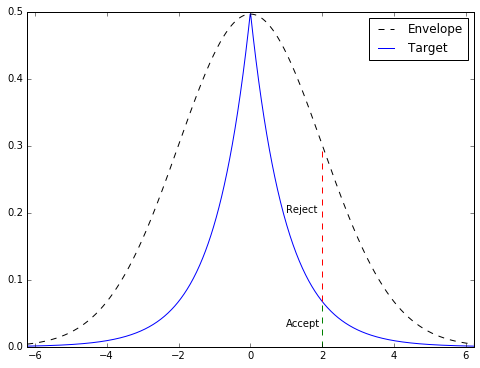

In [24]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Target = double gamma distribution
# Envelope = normal distribution 
dg = stats.dgamma(a=1)
norm = stats.norm(loc=0, scale=2)

# Generate samples for PDF
x = np.linspace(min(dg.ppf(0.001), norm.ppf(0.001)), max(dg.ppf(0.999), norm.ppf(0.999)), 1000)
dg_samples = dg.pdf(x)
norm_samples = norm.pdf(x)

# Find scaling constant for envelope 
M = max(dg_samples / norm_samples)

# Plot
df = pd.DataFrame({'Target': dg_samples, 'Envelope': M * norm_samples}, index=x)
ax = df.plot(style=['--', '-'], color=['black', 'blue'], figsize=(8,6))
ax.plot((2, 2), (0, dg.pdf(2)), 'g--')
ax.plot((2, 2), (dg.pdf(2), M * norm.pdf(2)), 'r--')
ax.text(1.0, 0.20, 'Reject')
ax.text(1.0, 0.03, 'Accept')

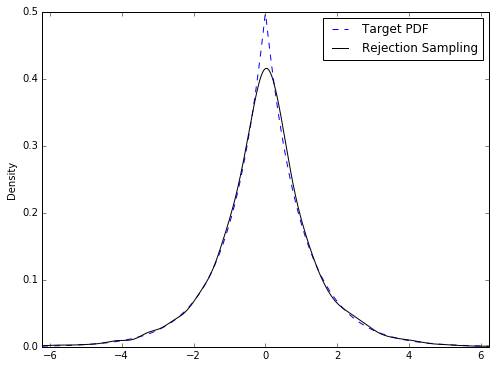

In [43]:
def rejection_sampling():
    while True:
        # Re-use global parameters from above
        x = np.random.normal(0, 2)
        envelope = M * norm.pdf(x)
        p = np.random.uniform(0, envelope)
        if p < dg.pdf(x):
            return x

# Generation samples from rejection sampling algorithm
samples = [rejection_sampling() for x in range(10000)]

# Plot Gaussian KDE vs. Target PDF (note: KDE will smooth histogram a bit)
df['Target'].plot(color='blue', style='--', figsize=(8,6))
pd.Series(samples).plot(kind='kde', color='black', style='-')
plt.legend(['Target PDF', 'Rejection Sampling'])

## References and Further Reading


* Wikipedia: [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain), [Examples of Markov Chains](https://en.wikipedia.org/wiki/Examples_of_Markov_chains), [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm), 
* [Markov Chain Definitions](http://nlp.stanford.edu/IR-book/html/htmledition/definition-1.html), *Introduction to Information Retrieval*, Christopher D. Manning, Prabhakar Raghavan & Hinrich Schütze.
* [Time-reversible Markov Chains](http://www.columbia.edu/~ks20/stochastic-I/stochastic-I-Time-Reversibility.pdf) (Karl Sigman, Columbia University)
* [Rejection Sampling](https://theclevermachine.wordpress.com/2012/09/10/rejection-sampling/) (Dustin Stansbury)

## Notes

List of Notes: [^1], [^2]

[^1]: Two examples: a Markov Chain that always just stays in the state it's currently in (non-unique steady state).  Or a markove chain that deterministicaly alternates between two states (no steady state).

[^2]: Here I'm describing [random walk MCMC methods](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo#Random_walk_Monte_Carlo_methods).  There are other types but these are by far the most common when talking about MCMC methods especially in the context of Bayesian inference techniques.
